# 项目描述
本项目通过电商行业常见指标对淘宝用户进行分析，包括用户行为、商品属性、用户画像等，进而对企业经营进行决策支持。

## 数据来源
本项目数据集来自阿里云天池提供的 [user_action](https://tianchi.aliyun.com/dataset/145889)

# 分析目的
1. 从不同时间维度的PV和UV及不同用户行为的PV探索用户访问规律，为商品运营提供建议
2. 分析各个流程的转化漏斗，结合二八定律细分商品的转化率和用户感兴趣率探索用户喜好，为商品运营提供建议
3. 从用户消费频次、每付费用户平均消费次数、复购率和复购周期探索用户消费规律，为商品运营提供建议。

# 结论与建议
| **结论** | **建议** |
| ---- | ---- |
| 用户活跃时段集中 **（20:00-22:00）**、**周四** 为峰值，周末流量下降明显。 | <ol><li>**20:00-22:00** 设置「整点秒杀」（如21:00限量5折商品），利用稀缺性刺激冲动消费</li><li>**周四**开展“周末补给”促销，**周六** 联动线下扫码发券，**周日** 推新品预售</li></ol> |
| 用户兴趣转化率低（整体转化 **1.04%**），超 **47%** 用户无购买行为，推荐精准度不足。 | <ol><li>优化推荐算法，针对性筛选用户兴趣商品</li><li>强化收藏/加购后的定向优惠推送（转化率达 **20.51%** 可重点利用）</li></ol> |
| **97%** 用户购买 **≤50次**，**87%** 用户复购周期 **≤5天**，**15天** 后复购意愿归零。 | <ol><li>重点维护 **3%** 高价值用户（购买>50次）</li><li>**5天内** 推送关联商品/限时折扣</li><li>**15天** 以上流失用户触发召回机制（如红包激励）</li></ol> |

# 数据处理
## 关键指标
| 指标 | 说明 |
| --- | --- |
| PV | 页面浏览量, 即网站或APP页面被用户访问的总次数 |
| UV | 独立访客数, 即访问网站或APP的独立用户数 |
| 转化率 | 指完成购买的用户与进入网站或APP的用户的比值 |
| 复购率 | 指在特定时间段内，再次购买商品的用户占总用户数的比例 |

## 数据理解
| 属性 | 说明 |
| --- | --- |
| user_id | 用户ID，脱敏 |
| item_id | 商品ID，脱敏 |
| behavior_type | 用户行为类型（包含点击、收藏、加购物车、购买），分别用1、2、3、4表示 |
| item_category | 商品品类，脱敏 |
| time | 用户行为发生的时间戳（精确到小时） |

## 数据获取

In [2]:
%pip install seaborn -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

In [4]:
warnings.filterwarnings('ignore') # 忽略警告
df = pd.read_csv('data/user_action.csv', encoding='ISO-8859-1')
df.head() # 读取数据

,user_id,item_id,behavior_type,item_category,time
0,98047837,232431562,1,4245,2014-12-06 02
1,97726136,383583590,1,5894,2014-12-09 20
2,98607707,64749712,1,2883,2014-12-18 11
3,98662432,320593836,1,6562,2014-12-06 10
4,98145908,290208520,1,13926,2014-12-16 21


In [5]:
# 查看数据
print('数据行数', len(df))
print('数据列数', len(df.columns))
print('用户数量', len(df['user_id'].unique()))
print('商品数量', len(df['item_id'].unique()))
print('商品品类数量', len(df['item_category'].unique()))
print('最大时间', df['time'].max())
print('最小时间', df['time'].min())

数据行数 12256906
数据列数 5
用户数量 10000
商品数量 2876947
商品品类数量 8916
最大时间 2014-12-18 23
最小时间 2014-11-18 00


由此可知，该数据集包含了10000个用户在2014年11月18日至2014年12月18日1个月内的的1225万多条购物行为数据，商品总数量超过287万，分布在8916个类目中。样本量足够大，可以支撑我们通过数据分析来完成结论洞察。

## 数据清洗

In [6]:
# 查看数据集缺失情况
df.isnull().sum()

user_id          0
item_id          0
behavior_type    0
item_category    0
time             0
dtype: int64

In [7]:
#将time列分割为 date 和 hour 两列，再加一列星期以便分析
df['date']= df['time'].map(lambda x:x.split(' ')[0])
df['hour']= df['time'].map(lambda x:x.split(' ')[1])
df['date']= pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.day_name()
df.head()

,user_id,item_id,behavior_type,item_category,time,date,hour,weekday
0,98047837,232431562,1,4245,2014-12-06 02,2014-12-06,02,Saturday
1,97726136,383583590,1,5894,2014-12-09 20,2014-12-09,20,Tuesday
2,98607707,64749712,1,2883,2014-12-18 11,2014-12-18,11,Thursday
3,98662432,320593836,1,6562,2014-12-06 10,2014-12-06,10,Saturday
4,98145908,290208520,1,13926,2014-12-16 21,2014-12-16,21,Tuesday


In [8]:
df.dtypes # 查看数据类型

user_id                   int64
item_id                   int64
behavior_type             int64
item_category             int64
time                     object
date             datetime64[ns]
hour                     object
weekday                  object
dtype: object

In [9]:
# 数据类型转换
df['user_id']=df['user_id'].astype('object')
df['item_id']=df['item_id'].astype('object')
df['item_category']=df['item_category'].astype('object')
df['date']=pd.to_datetime(df['date'])
df['hour']=df['hour'].astype('int64')
df.dtypes

user_id                  object
item_id                  object
behavior_type             int64
item_category            object
time                     object
date             datetime64[ns]
hour                      int64
weekday                  object
dtype: object

# 数据分析 & 可视化
## Part1. 流量分析
### 1. 日流量PV和UV分析

In [10]:
pv_daily = df.groupby('date')['user_id'].count().reset_index().rename(columns={'user_id':'pv_daily'})
# pv_daily

In [11]:
uv_daily = df.groupby('date')['user_id'].apply(lambda x: len(x.unique())).reset_index().rename(columns={'user_id':'uv_daily'})
# uv_daily

我们得到了基于日流量PV和UV的数据，如果直接观察上述结果，会比较耗时且不太直观，我们来看看可视化结果：

Text(0.5, 1.0, 'uv_daily')

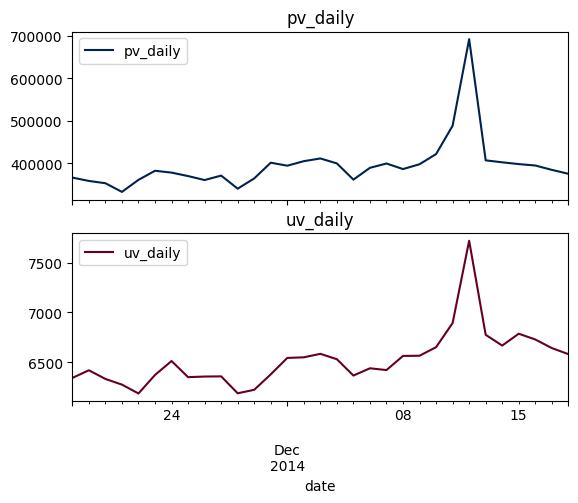

In [12]:
fig, axes = plt.subplots(2, 1, sharex=True)
pv_daily.plot(x='date', y='pv_daily', ax=axes[0], colormap='cividis')
uv_daily.plot(x='date', y='uv_daily', ax=axes[1], colormap='RdGy')
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')

可以看出，不管是PV还是UV趋势，均在12号的时候出现了一个尖峰，这正是著名的双十二大促节的用户集中消费导致的变化。 通过简单的数据分析和可视化工具，这是我们从数据中观察到的第一个结论。

### 2.小时流量PV和UV分析
上面的对不同访问量进行分析，其分析的时间跨度是每天。另外从我们的直觉可以知道，用户在一天当中对淘宝的使用也是有一定规律的。为了探索这个规律，我们将按照每小时统计用户的访问量和独立访问量。同pv_daily, uv_daily分析，我们完成如下代码：

In [13]:
pv_hour = df.groupby('hour')['user_id'].count().reset_index().rename(columns={'user_id':'pv_hour'})
# pv_hour

In [14]:
uv_hour = df.groupby('hour')['user_id'].apply(lambda x: len(x.unique())).reset_index().rename(columns={'user_id':'uv_hour'})
# uv_hour

Text(0.5, 1.0, 'uv_hour')

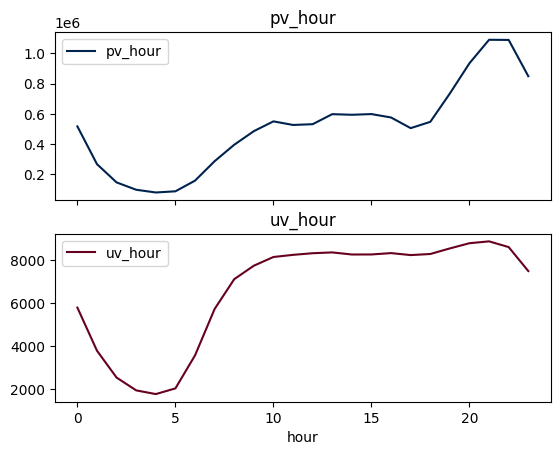

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True)
pv_hour.plot(x='hour', y='pv_hour', ax=axes[0], colormap='cividis')
uv_hour.plot(x='hour', y='uv_hour', ax=axes[1], colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')

可以看出，PV的高峰值出现在20点之后，可能的原因是淘宝的主力消费人群是上班族，这部分群体在下班后开始使用淘宝浏览购物；UV的值比较恒定，上午10点之后便没有出现大的波动，一个可能的原因是许多用户早晨也会刷一下淘宝，比如查看物流状态等，UV值在一天之内就不会再有大的变化波动了。 另外也可以看出，半夜12点之后，PV/UV的趋势都是下降趋势。

### 3.周流量PV和UV分析

In [16]:
pv_weekday = df.groupby('weekday')['user_id'].count().reset_index().rename(columns={'user_id':'pv_weekday'})
# pv_weekday

In [17]:
uv_weekday = df.groupby('weekday')['user_id'].apply(lambda x: len(x.unique())).reset_index().rename(columns={'user_id':'uv_weekday'})
# uv_weekday 

Text(0.5, 1.0, 'uv_weekday')

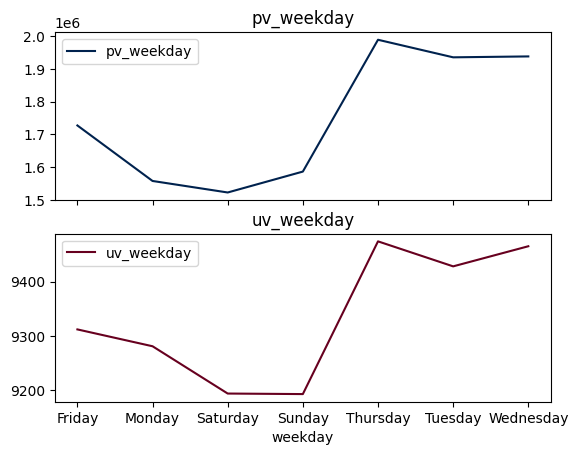

In [18]:
fig, axes = plt.subplots(2, 1, sharex=True)
pv_weekday.plot(x='weekday', y='pv_weekday', ax=axes[0], colormap='cividis')
uv_weekday.plot(x='weekday', y='uv_weekday', ax=axes[1], colormap='RdGy')
axes[0].set_title('pv_weekday')
axes[1].set_title('uv_weekday')

可见，周四是每周访问量最高的一天，周二、周三次之，周末和周一相对较少，这可能是由于上班族周末选择消费、放松的方式更多样化，减少了淘宝的使用量。

### 4.不同用户行为流量分析

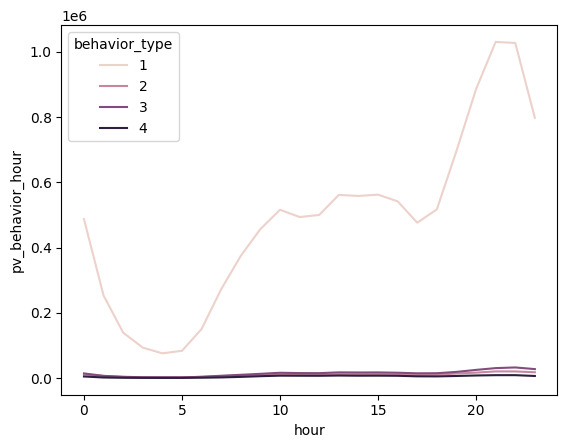

In [19]:
# 统计不同行为的用户访问量
pv_behavior_hour = df.groupby(['behavior_type', 'hour'])['user_id'].count().reset_index().rename(columns={'user_id': 'pv_behavior_hour'})
ax = sns.lineplot(x='hour', y='pv_behavior_hour', hue='behavior_type', data=pv_behavior_hour)

从上图可以清楚的看出，用户的点击行为数量远远大于收藏、加购物车、购买行为的数量，符合常识。从时间上来看，早上和下午用户点击量有明显的上升趋势，晚上20点左右点击量最大。

<Axes: xlabel='hour', ylabel='pv_behavior_hour'>

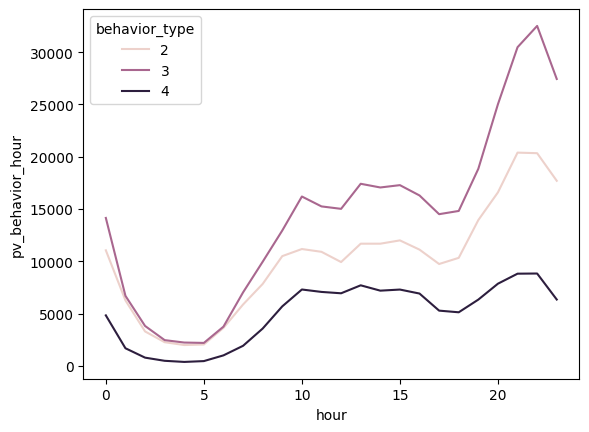

In [20]:
# 为了能更好的分析收藏、加购物车、购买行为，我们去掉点击这一行为。
sns.lineplot(x='hour',y='pv_behavior_hour',hue='behavior_type',data=pv_behavior_hour[pv_behavior_hour.behavior_type!=1])

可见这四种行为趋势变化是一样的，晚上20点左右是用户行为的高峰期，而在早上10点前是用户行为的低谷期。


### 结论一

**日周期规律**
- 黄金时段：20:00-22:00（用户下班后休闲时段）
    - 用户心理：工作结束后放松身心
    - 用户行为：深度浏览、高客单价商品决策
- 低谷时段：早上
    - 用户可能在工作或其他

**周周期规律**
- 周四峰值：工作日购物需求集中释放
    - 用户心理：周末消费前准备
    - 数据对比：周四PV比周末高29%
- 周末低谷：用户注意力分散至线下场景
    - 周六日流量最低，约为周四流量的 **77.5%** 左右

**建议**：
- 20:00-22:00设置「整点秒杀」（如21:00限量5折商品），利用稀缺性刺激冲动消费
- 周四「周末补给站」主题促销（例如食品/日用品满199减50）
- 周六「线下体验店扫码领券」活动
- 周日「预售专场」（下周新品抢先预定）


## 用户喜好分析
### 1. 转化率分析
按照转化流程对用户购买行为进行划分，查看各节点之间的转化情况

点击浏览商品(pv) -- 收藏+加购商品(fav+cart) -- 支付购买商品(buy)

结合tableau可视化:

![转化率漏斗图](image/image.png)

由此可见，点击浏览商品(pv) -> 收藏+加购商品(fav+cart) 的转化率为 **5.07%** ，收藏+加购商品(fav+cart) -> 支付购买商品(buy) 的转化率为 **20.51%** ,而点击浏览商品(pv) -> 支付购买商品(buy) 的转化率为 **1.04%**。这里最主要的原因是用户浏览的商品中，大部分商品都没有收藏（用户不感兴趣），所以转化率较低。

### 2. 用户行为与商品品类的关系分析
造成转换率的原因，我们可以假设是推荐系统未精准推荐用户感兴趣的商品，或者推荐的商品与用户的兴趣不匹配。我们可以进一步联合商品分析来验证。

In [29]:
df['operation'] = 1
df_category = df[df.behavior_type != 2].groupby(['item_category', 'behavior_type']) \
.operation.count().unstack(1).rename(columns={1: 'pv', 3: 'cart', 4: 'buy'}).fillna(0)
# 购买转化率计算 （购买数/浏览量）
df_category['buy_conversion_rate'] = df_category['buy'] / df_category['pv']
# 加购转化率计算 （加购数/浏览量）
df_category['cart_conversion_rate'] = df_category['cart'] / df_category['pv']
df_category.head()

behavior_type,pv,cart,buy,buy_conversion_rate,cart_conversion_rate
item_category,,,,,
2,3.0,0.0,0.0,0.000000,0.000000
3,3.0,0.0,0.0,0.000000,0.000000
4,1.0,0.0,0.0,0.000000,0.000000
6,10.0,0.0,0.0,0.000000,0.000000
8,976.0,4.0,4.0,0.004098,0.004098


In [73]:
# 异常值处理
df_category = df_category.fillna(0)
df_category = df_category[df_category['buy_conversion_rate'] >= 0]
df_category = df_category[df_category['buy_conversion_rate'] <= 1]
df_category = df_category[df_category['cart_conversion_rate'] >= 0]
df_category = df_category[df_category['cart_conversion_rate'] <= 1]

<Axes: xlabel='buy_conversion_rate', ylabel='Density'>

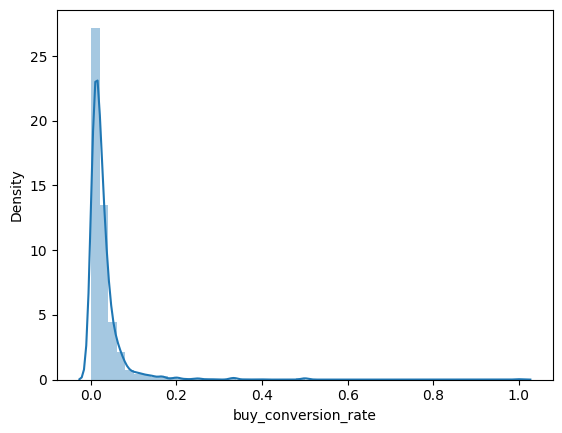

In [74]:
# 可视化购买转化率
sns.distplot(df_category['buy_conversion_rate'])

<Axes: xlabel='cart_conversion_rate', ylabel='Density'>

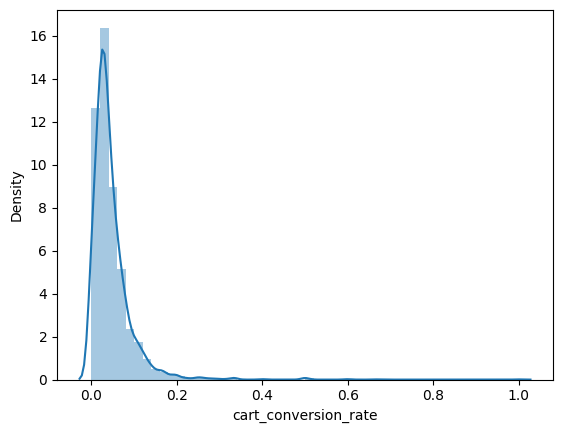

In [75]:
# 可视化加购转化率
sns.distplot(df_category['cart_conversion_rate'])

In [ ]:
# 将购买转化率分三类查看各类占比例
df_convert_rate = pd.cut(df_category['buy_conversion_rate'], [-1, 0, 0.1, 1]).value_counts()
df_convert_rate= df_convert_rate / df_convert_rate.sum()
df_convert_rate

buy_conversion_rate
(0.0, 0.1]     0.502693
(-1.0, 0.0]    0.476885
(0.1, 1.0]     0.020422
Name: count, dtype: float64

In [ ]:
# 将加购转化率分三类查看各类占比例
df_interest_rate = pd.cut(df_category['cart_conversion_rate'], [-1, 0, 0.1, 1]).value_counts()
df_interest_rate = df_interest_rate / df_interest_rate.sum()
df_interest_rate

cart_conversion_rate
(0.0, 0.1]     0.538487
(-1.0, 0.0]    0.390373
(0.1, 1.0]     0.071140
Name: count, dtype: float64

由以上分析结果可见，商品的购买率（浏览 -> 购买）和感兴趣率（浏览 -> 加购物车）基本都在 **0.1** 以内，购买率 **超过0.1** 的用户仅仅只有 **2.04%**， 有 **47%** 的用户几乎不会购买商品，同时从感兴趣率来看，有 **39%** 的用户对商品不感兴趣。

### 3. 二八定律分析
二八定律：在任何一组东西中，最重要的只占其中一小部分，约20%，其余80%尽管是多数，却是次要的，因此又称二八定律。

In [50]:
df_category = df_category[df_category['buy'] > 0]
value_10 = df_category['buy'].sum()
value_8 = value_10 * 0.8
# 按照销量降序排序
df_category = df_category.sort_values(by='buy', ascending=False)
# 添加一列累计购买量按行统计
df_category['cunmsum_buy'] = df_category['buy'].cumsum()

df_category['label'] = df_category['cunmsum_buy'].map(lambda x: '前80%' if x <= value_8 else '后20%')
df_category.head()

behavior_type,pv,cart,buy,buy_conversion_rate,cart_conversion_rate,cunmsum_buy,label
item_category,,,,,,,
6344,85369.0,3822.0,2208.0,0.025864,0.044770,2208.0,前80%
1863,371738.0,9309.0,2000.0,0.005380,0.025042,4208.0,前80%
5232,135506.0,4486.0,1611.0,0.011889,0.033106,5819.0,前80%
6977,22806.0,2007.0,1324.0,0.058055,0.088003,7143.0,前80%
8877,63396.0,1974.0,1072.0,0.016910,0.031138,8215.0,前80%


In [52]:
df_category.groupby('label')['label'].count() /df_category['label'].count()

label
前80%    0.155727
后20%    0.844273
Name: label, dtype: float64

以上结果说明 前 **80%** 销量由 **15.6** 左右的商品品类承包，接近二八原则。

对于传统零售行业，因为成本高，因此只能局限于这前 **20%** 的商品提供利润。

对于电子商务，空间成本极剧减少乃至为 **0**，使后80%的商品也可以销售出去，因此将长尾部分的商品优化推荐好，能够给企业带来更大的收益。

### 4. 商品销量前20和访问量前20

In [53]:
#取商品购买量top20
buy_top20 = df_category.nlargest(20, 'buy')
#取商品访问量top20
pv_top20 = df_category.nlargest(20, 'pv')
#取重合商品类别，需要注意到这里商品列刚好是索引列，所以需要加index，intersection()函数
categories = set(buy_top20.index).intersection(set(pv_top20.index))
categories

{1863,
 3064,
 4370,
 5027,
 5232,
 5399,
 5894,
 6344,
 6513,
 9516,
 10392,
 10894,
 11279,
 13230}

可以看到重叠的商品类别有 **14** 个，这 **14** 个品类既有流量又有一定的转化能力，可以针对性地丰富品类内的商品数，并且针对性优化商品利益点，提高高流量品类内的商品转化。

### 结论二

用户访问到购买的整体转化率仅 **1.04%**，点击到收藏+加购的转化率为 **5.07%**，所有商品的转化率和感兴趣率基本都在 **0.1** 以内，商品购买转化率达到 **0.1以上** 的仅 **2.04%** 的用户，有 **超过47%** 的用户几乎不会发生购买行为、**39%** 的用户对商品不感兴趣，而收藏+加购到购买的转化率有 **20.51%**。

**建议**：

说明客户对于感兴趣的商品成交率较大，但是存在所有推荐商品对客户的感兴趣率几乎仅有 **0.1**，运营部需要特别重视此问题，精准定位客户喜好，针对推荐系统进行调整，以便达到成交率的有效提升。

## 用户消费频率分析
### 1. 用户消费频次

<Axes: xlabel='user_id'>

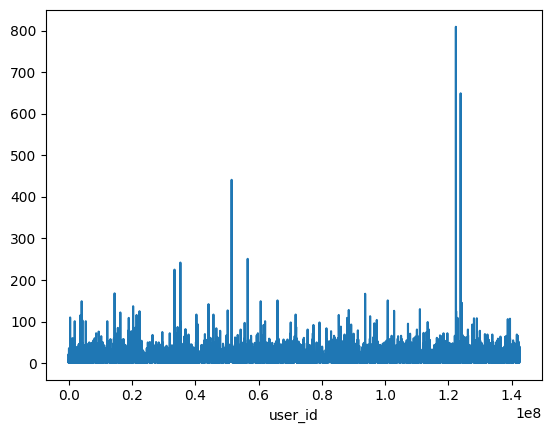

In [55]:
user_buy = df[df.behavior_type == 4].groupby('user_id')['behavior_type'].count()
user_buy.plot(x='user_id', y='buy_count')

In [56]:
#将购买次数分三类查看各类占比例
buy_rate = pd.cut(df[df.behavior_type==4].groupby('user_id')['behavior_type'].count(), [0, 50, 200, 1000]).value_counts()
#计算各个分组分别在整体数据集中的占比
buy_rate = buy_rate / buy_rate.sum()
buy_rate

behavior_type
(0, 50]        0.967702
(50, 200]      0.031623
(200, 1000]    0.000675
Name: count, dtype: float64

可以看到，在一个月内:
1. 将近 **97%** 用户的购买次数均不超过 **50** 次，这期间还包括了双十二当天的集中购物，排除双十二高峰，实际消费次数应当会更少。
2. 仅有 **3%** 用户购买次数 **超过50次**，这部分高频消费的用户可以看作是忠实的超级用户，应当重点留存。
3. 存在 **超过200** 次的用户，有可能属于刷单行为。

### 2. ARPPU分析
ARPPU(Average Revenue Per Paying User)表示每付费用户平均收益，计算公式: ARPPU = 总收入 / 付费用户数。

该数据集中没有收益金额，这里我们改为度量每付费用户平均消费次数，计算公式: ARPPU = 总消费次数 / 付费用户数。

<Axes: xlabel='arppu', ylabel='Density'>

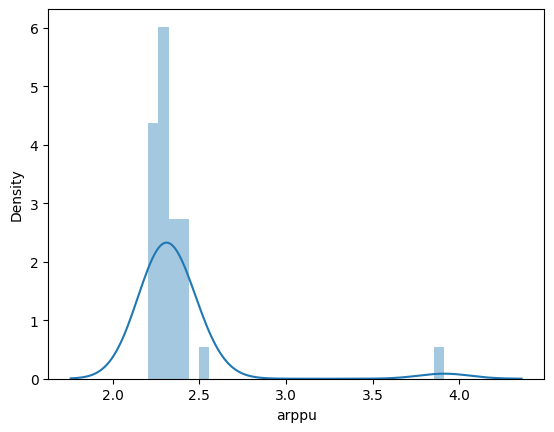

In [90]:
user_arppu = df[df.behavior_type == 4].groupby(['date', 'user_id'])['behavior_type'].count().rename('arppu')
arppu = user_arppu.groupby('date').apply(lambda x: x.sum() / x.count())
sns.distplot(arppu)

In [84]:
arppu

date
2014-11-18    2.423652
2014-11-19    2.439444
2014-11-20    2.320375
2014-11-21    2.271429
2014-11-22    2.530120
2014-11-23    2.330780
2014-11-24    2.248031
2014-11-25    2.313961
2014-11-26    2.402824
2014-11-27    2.403405
2014-11-28    2.231623
2014-11-29    2.331881
2014-11-30    2.357236
2014-12-01    2.359083
2014-12-02    2.284543
2014-12-03    2.289334
2014-12-04    2.328707
2014-12-05    2.223041
2014-12-06    2.253444
2014-12-07    2.320741
2014-12-08    2.204384
2014-12-09    2.413576
2014-12-10    2.230236
2014-12-11    2.226363
2014-12-12    3.913523
2014-12-13    2.245320
2014-12-14    2.312749
2014-12-15    2.313460
2014-12-16    2.285455
2014-12-17    2.302548
2014-12-18    2.310567
Name: behavior_type, dtype: float64

由此可见，用户每日平均消费次数在区间 (2, 2.5) 内波动，双十二当天超过了 **3.9** 次，说明用户可能会进行加购但在双十二当天集中购买。

### 3. 复购情况分析
复购是指消费者再次购买同一品牌或同一产品的行为。通过分析复购情况，可以了解消费者的购买习惯和需求，为产品开发和营销提供参考。

一般来说，复购是指对产品的重复购买行为。但是这个定义在商业上是不精确的，假若一个用户在一天内多次在淘宝购买商品，不能说明这件用户对淘宝的依赖（有可能是某位用户只是第一次用，但是买的量大）。因此商业分析过程中，对于复购行为进行明确的定义。这里的复购是指：两天以上都在该平台产生了购买行为，需要指出一天多次的购买不算是复购。

计算方法：复购率 = 复购用户数 / 有购买行为用户数

In [92]:
user_pay = df[df.behavior_type == 4].groupby('user_id')['date'].apply(lambda x: x.nunique())
user_pay

user_id
4913         5
6118         1
7528         6
7591         9
12645        4
            ..
142376113    1
142412247    7
142430177    5
142450275    8
142455899    7
Name: date, Length: 8886, dtype: int64

In [93]:
# 计算复购率
repeat_buy_rate = user_pay[user_pay > 1].count() / user_pay.count()
repeat_buy_rate

np.float64(0.8717083051991897)

可见，复购率达到了 **87%** ！这是相当不错的结果！

### 4. 复购周期分析
除了以上对复购频次的统计，还需要对复购意向做进一步的探究，了解用户多久复购一次。


In [99]:
user_buy = df[df.behavior_type==4].groupby(['user_id', 'date'])['operation'].count().reset_index()
user_buy.head()

,user_id,date,operation
0,4913,2014-12-01,1
1,4913,2014-12-07,2
2,4913,2014-12-11,1
3,4913,2014-12-13,1
4,4913,2014-12-16,1


In [110]:
repeat_buy_cycle = user_buy.groupby('user_id')['date'].apply(lambda x: x.sort_values().diff(1).dt.days.dropna())
repeat_buy_cycle.head()

user_id   
4913     1    6.0
         2    4.0
         3    2.0
         4    3.0
7528     7    4.0
Name: date, dtype: float64

第1列为索引列，即为user_id列

第二列为该条记录在原始dataframe表中的索引位置，即data_user_buy的默认索引

第三列为同一用户相邻两个购买日期的求差结果。

Text(0, 0.5, 'count')

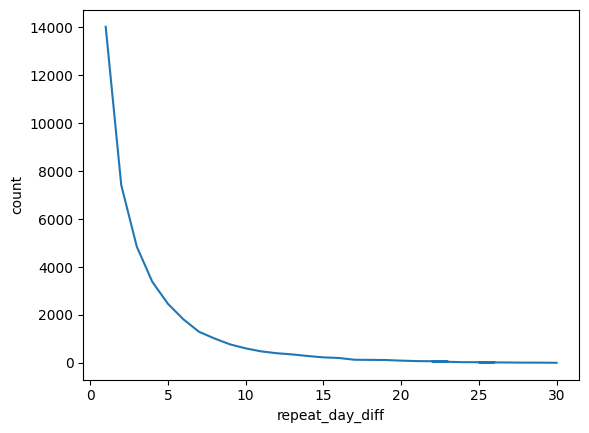

In [111]:
repeat_buy_cycle.value_counts().plot(kind='line')

plt.xlabel('repeat_day_diff')
plt.ylabel('count')

<Axes: xlabel='date', ylabel='Density'>

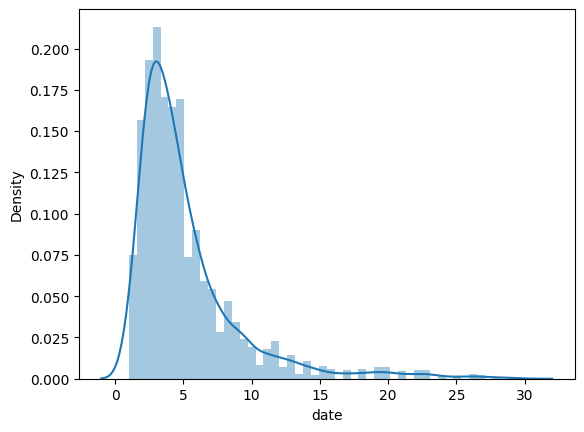

In [112]:
sns.distplot(repeat_buy_cycle.reset_index().groupby('user_id').date.mean())

可以看出：

1. 大部分用户的复购行为发生在5天之内，在第5天复购的行为出现了明显的拐点。
2. 不同用户平均复购时间呈正态分布，但是总体来看，呈现逐渐下降趋势。

### 结论三
将近97%用户的购买次数均不超过 **50** 次，付费用户平均每日消费次数在 **2-2.5** 次之间波动，复购率较高达到 **87.17%**，复购周期主要集中在 **1-5天**。

**建议**：

重点留存 **3%** 购买次数 **超过50次** 的忠实用户，且大部分用户的复购行为发生在 **5天** 之内，建议在这个时候采取营销策略提升用户的购买意图，**超过15天**后，复购的意愿基本已经趋于 **0**，此时可以考虑采取召回策略，增加复购的可能性，防止用户流失。